<a href="https://colab.research.google.com/github/Zhang-Cheng-76200/Random-Walk-Prediction/blob/main/random_walk_prediction_sp500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fusion for Random Walk Time Series Forecasting

Achieve accurate point forecasting through the fusion of binary classification and naive forecasting.

In [ ]:
import keras.backend as K
import tensorflow as tf

import keras
from keras import backend as K
from keras import initializers, layers, models, optimizers, callbacks, utils
from keras.models import load_model
from keras.models import model_from_json

from keras.initializers import glorot_uniform

from keras.initializers import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils import *

from keras import losses
from tensorflow.python.platform import tf_logging as logging

import os
import copy
import pickle
import pandas as pd
import math
import scipy
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

In [ ]:
import statsmodels.api as sm
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.utils import resample

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
import random

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE

In [ ]:
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.0 MB/s eta 0:00:00


In [ ]:
# Set seed
from numpy.random import seed
# Set seed for Python's random module
random.seed(1)

# Set seed for NumPy's random functions
np.random.seed(1)

# Set seed for TensorFlow to ensure reproducibility in model training
tf.random.set_seed(1)

## Raw data

A couple of things to note:

- There is no need to save the data points as numpy arrays, regular lists is fine.
- The `time` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `series` list.
- The values of the `series` should be of `float` type. You can use Python's built-in `float` function to ensure this.

Begin by looking at the structure of the xlsx file that contains the data:

In [ ]:
from google.colab import drive
drive.mount ('gdrive')

Mounted at gdrive


In [ ]:
SP500_raw = pd.read_excel('/content/gdrive/MyDrive/Random_walk_prediction/SP500.xlsx')

In [ ]:
SP500_raw

,Date,Open,High,Low,Close,Volume
0,2010-04-01 00:00:00,1116.56,1133.87,1116.56,1132.99,3991400000
1,2010-05-01 00:00:00,1132.66,1136.63,1129.66,1136.52,2491020000
2,2010-06-01 00:00:00,1135.71,1139.19,1133.95,1137.14,4972660000
3,2010-07-01 00:00:00,1136.27,1142.46,1131.32,1141.69,5270680000
4,2010-08-01 00:00:00,1140.52,1145.39,1136.22,1144.98,4389590000
...,...,...,...,...,...,...
2511,12/24/19,3225.45,3226.43,3220.51,3223.38,1296530000
2512,12/26/19,3227.20,3240.08,3227.20,3239.91,2164540000
2513,12/27/19,3247.23,3247.93,3234.37,3240.02,2429150000
2514,12/30/19,3240.09,3240.92,3216.57,3221.29,3021720000


In [ ]:
series = SP500_raw.iloc[:,4] # close price
time = []
for i in range(0, len(series)):
  time.append(i)

In [ ]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME = np.array(time)
    SERIES = np.array(series)
    SPLIT_TIME = 400          # data splitting, 200 samples are thevalidation set and 200 samples are the test set.
    WINDOW_SIZE = 50          # sequence length
    BATCH_SIZE = 32           # batch size

In [ ]:
# Calculate statistics
mean_price = np.mean(G.SERIES)
std_dev = np.std(G.SERIES)
min_price = np.min(G.SERIES)
median_price = np.median(G.SERIES)
max_price = np.max(G.SERIES)

# Print results
print(f"Mean: {mean_price:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"Minimum: {min_price:.2f}")
print(f"Median: {median_price:.2f}")
print(f"Maximum: {max_price:.2f}")

Mean: 1962.61
Standard Deviation: 588.79
Minimum: 1022.58
Median: 1986.48
Maximum: 3240.02


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

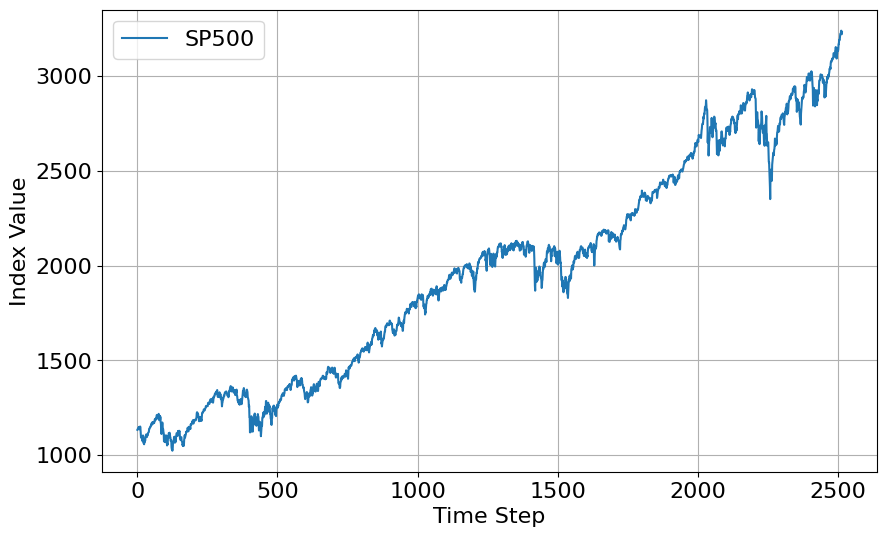

In [ ]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["SP500"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/SP500_original.tif")
plt.show()

## Random Walk and Autocorrelation

We can calculate the correlation between each observation and the observations at previous time steps. A plot of these correlations is called an autocorrelation plot or a correlogram.

Given the way that the random walk is constructed, we would expect a strong autocorrelation with the previous observation and a linear fall off from there with previous lag values.

We can use the autocorrelation_plot() function in Pandas to plot the correlogram for the random walk.

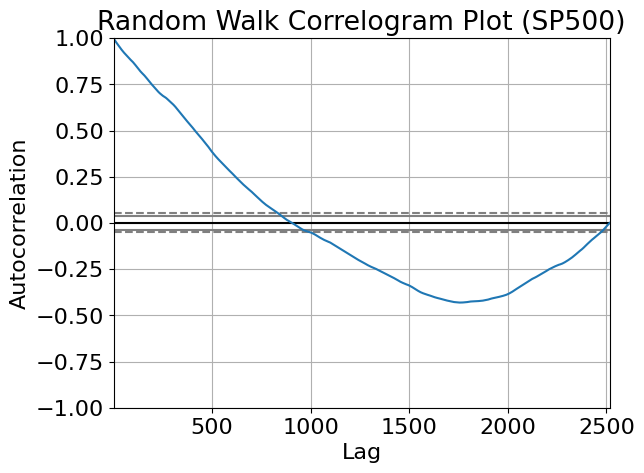

<Figure size 640x480 with 0 Axes>

In [ ]:
autocorrelation_plot(G.SERIES)
plt.title("Random Walk Correlogram Plot (SP500)")
plt.show()
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/SP500_correlation.tif")

## Random Walk and Stationarity

We can confirm this using a statistical significance test, specifically the Augmented Dickey-Fuller test.

We can perform this test using the adfuller() function in the statsmodels library. The complete example is listed below.

In [ ]:
# statistical test
result = adfuller(G.SERIES)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.416927
p-value: 0.982117
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


The null hypothesis of the test is that the time series is non-stationary.

Therefore, we can say that the time series does appear to be non-stationary with a low likelihood of the result being a statistical fluke.

## Pre-defined funcitons

In [ ]:
def min_max_normalization(series):
  series = (series - min(series_train))/(max(series_train) - min(series_train))
  return series

In [ ]:
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)

In [ ]:
def train_test_split_classification(features, labels, time_step=G.SPLIT_TIME):

    X_train = features[:-G.SPLIT_TIME]
    y_train = labels[:-G.SPLIT_TIME]
    X_test = features[-G.SPLIT_TIME:]
    y_test = labels[-G.SPLIT_TIME:]

    return X_train, y_train, X_test, y_test

In [ ]:
def train_test_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:-G.SPLIT_TIME]
    series_train = series[:-G.SPLIT_TIME]
    time_test = time[-G.SPLIT_TIME:]
    series_test = series[-G.SPLIT_TIME:]

    return time_train, series_train, time_test, series_test

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
def reverse_normalization(series):
  series = series * (max(series_train) - min(series_train)) + min(series_train)
  return series

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    rmse = tf.math.sqrt(mse).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    mape = tf.keras.metrics.mean_absolute_percentage_error(true_series, forecast).numpy()
    return mae, mse

## Data preprocessing

In [ ]:
# Split the dataset
time_train, series_train, time_test, series_test = train_test_split(G.TIME, G.SERIES)
series_norm = min_max_normalization(G.SERIES)
series_train_norm = series_norm[:-G.SPLIT_TIME]
series_test_norm = series_norm[-G.SPLIT_TIME:]

## Rule-based movement prediction sifting

### Feature engineering

In [ ]:
SP500_raw['Date'] = pd.to_datetime(SP500_raw['Date'])
SP500_raw['Date'] = SP500_raw['Date'].dt.strftime('%Y-%m-%d')
series = SP500_raw.iloc[:,4] # close price
time = []
for i in range(0, len(series)):
  time.append(i)

TIME = np.array(time)
SERIES = np.array(series)

SP500_raw['return'] = SP500_raw['Close'].pct_change()
SP500_raw['SMA_5'] = SP500_raw['Close'].transform(lambda x: x.rolling(window = 5).mean())
SP500_raw['SMA_15'] = SP500_raw['Close'].transform(lambda x: x.rolling(window = 15).mean())
SP500_raw['SMA_ratio'] = SP500_raw['SMA_15'] / SP500_raw['SMA_5']
SP500_raw['SMA5_Volume'] = SP500_raw['Volume'].transform(lambda x: x.rolling(window = 5).mean())
SP500_raw['SMA15_Volume'] = SP500_raw['Volume'].transform(lambda x: x.rolling(window = 15).mean())
SP500_raw['SMA_Volume_Ratio'] = SP500_raw['SMA5_Volume']/SP500_raw['SMA15_Volume']
SP500_raw['prev_close'] = SP500_raw['Close'].shift(1)
SP500_raw['TR'] = np.maximum((SP500_raw['High'] - SP500_raw['Low']),
                    np.maximum(abs(SP500_raw['High'] - SP500_raw['prev_close']),
                    abs(SP500_raw['prev_close'] - SP500_raw['Low'])))
SP500_raw['Lowest_5D'] = SP500_raw['Low'].transform(lambda x: x.rolling(window = 5).min())
SP500_raw['High_5D'] = SP500_raw['High'].transform(lambda x: x.rolling(window = 5).max())
SP500_raw['Lowest_15D'] = SP500_raw['Low'].transform(lambda x: x.rolling(window = 15).min())
SP500_raw['High_15D'] = SP500_raw['High'].transform(lambda x: x.rolling(window = 15).max())
SP500_raw['Stochastic_5'] = ((SP500_raw['Close'] - SP500_raw['Lowest_5D'])/(SP500_raw['High_5D'] - SP500_raw['Lowest_5D']))*100
SP500_raw['Stochastic_15'] = ((SP500_raw['Close'] - SP500_raw['Lowest_15D'])/(SP500_raw['High_15D'] - SP500_raw['Lowest_15D']))*100
SP500_raw['Stochastic_%D_5'] = SP500_raw['Stochastic_5'].rolling(window = 5).mean()
SP500_raw['Stochastic_%D_15'] = SP500_raw['Stochastic_5'].rolling(window = 15).mean()
SP500_raw['Stochastic_Ratio'] = SP500_raw['Stochastic_%D_5']/SP500_raw['Stochastic_%D_15']
SP500_raw['Diff'] = SP500_raw['Close'].transform(lambda x: x.diff())
SP500_raw['Up'] = SP500_raw['Diff']
SP500_raw.loc[(SP500_raw['Up']<0), 'Up'] = 0
SP500_raw['Down'] = SP500_raw['Diff']
SP500_raw.loc[(SP500_raw['Down']>0), 'Down'] = 0
SP500_raw['Down'] = abs(SP500_raw['Down'])
SP500_raw['avg_5up'] = SP500_raw['Up'].transform(lambda x: x.rolling(window=5).mean())
SP500_raw['avg_5down'] = SP500_raw['Down'].transform(lambda x: x.rolling(window=5).mean())
SP500_raw['avg_15up'] = SP500_raw['Up'].transform(lambda x: x.rolling(window=15).mean())
SP500_raw['avg_15down'] = SP500_raw['Down'].transform(lambda x: x.rolling(window=15).mean())
SP500_raw['RS_5'] = SP500_raw['avg_5up'] / SP500_raw['avg_5down']
SP500_raw['RS_15'] = SP500_raw['avg_15up'] / SP500_raw['avg_15down']
SP500_raw['RSI_5'] = 100 - (100/(1+SP500_raw['RS_5']))
SP500_raw['RSI_15'] = 100 - (100/(1+SP500_raw['RS_15']))
SP500_raw['RSI_ratio'] = SP500_raw['RSI_5']/SP500_raw['RSI_15']
SP500_raw['5Ewm'] = SP500_raw['Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
SP500_raw['15Ewm'] = SP500_raw['Close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
SP500_raw['MACD'] = SP500_raw['15Ewm'] - SP500_raw['5Ewm']
SP500_raw['15MA'] = SP500_raw['Close'].transform(lambda x: x.rolling(window=15).mean())
SP500_raw['SD'] = SP500_raw['Close'].transform(lambda x: x.rolling(window=15).std())
SP500_raw['upperband'] = SP500_raw['15MA'] + 2*SP500_raw['SD']
SP500_raw['lowerband'] = SP500_raw['15MA'] - 2*SP500_raw['SD']
SP500_raw['RC'] = SP500_raw['Close'].transform(lambda x: x.pct_change(periods = 15))
SP500_raw['label'] = 1

In [ ]:
# Use .loc to set 'label' values conditionally
SP500_raw.loc[SP500_raw['return'] > 0, 'label'] = 1
SP500_raw.loc[SP500_raw['return'] <= 0, 'label'] = 0

In [ ]:
SP500_raw = SP500_raw[100:]
SP500_raw = SP500_raw.iloc[:, 1:47]
SP500_raw = SP500_raw.drop('RS_5', axis=1)

In [ ]:
SP500_new = SP500_raw
feature_table = SP500_new.iloc[:-1, 0:42]
labels = SP500_new['label']
labels = labels[1:]
labels = list(labels)
labels = pd.DataFrame(labels, columns=['Label'])

X_train, y_train, X_test, y_test = train_test_split_classification(feature_table, labels)

scaler = MinMaxScaler()
X_train_minmax = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_minmax = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train = X_train_minmax.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test_minmax.to_numpy()
y_test = y_test.to_numpy()
y_train = y_train.ravel()
y_test = y_test.ravel()

print(SP500_new.shape, feature_table.shape, X_train.shape, X_test.shape)

(2416, 43) (2415, 42) (2015, 42) (400, 42)


In [ ]:
# Assuming X_train, y_train are already defined
# # Divide X_test, y_test into two parts: validation and test
X_val, y_val = X_test[0:200], y_test[0:200]
X_test_final, y_test_final = X_test[200:400], y_test[200:400]

### Model training and prediction

In [ ]:
# Variables to keep track of the best model and its accuracy
best_accuracy = 0
best_model = None

# Initialize list to store validation accuracies
individual_accuracies_val = []

# Number of trials
n_estimators = 32

for i in range(n_estimators):
    # Initialize NuSVC with random nu parameter and enable probability estimates
    nu_value = np.random.uniform(0.1, 0.9)  # nu should be between 0 and 1
    model = NuSVC(nu=nu_value, kernel='rbf', gamma='scale', probability=True)

    # Train the model on the full training set
    model.fit(X_train, y_train)

    # Evaluate on the validation set using predicted probabilities
    val_pred_probabilities = model.predict_proba(X_val)[:, 1]
    val_pred_binary = (val_pred_probabilities > 0.5).astype(int)
    accuracy_val = accuracy_score(y_val, val_pred_binary)

    # Update the best model based on validation accuracy
    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        best_model = model

    # Store accuracy for this model
    individual_accuracies_val.append(accuracy_val)

# Use the best model to predict on the test set
test_pred_probabilities = best_model.predict_proba(X_test_final)[:, 1]
test_pred_binary = (test_pred_probabilities > 0.5).astype(int)
accuracy_test = accuracy_score(y_test_final, test_pred_binary)

# Print results
print(f"Best Validation Set Accuracy: {best_accuracy * 100:.2f}%")
print(f"Test Set Accuracy with Best Model: {accuracy_test * 100:.2f}%")

Best Validation Set Accuracy: 56.50%
Test Set Accuracy with Best Model: 56.50%


In [ ]:
# Generate naive forecast for the training set
naive_train = G.SERIES[:-201]
raw_y_train =  G.SERIES[1:-200]

# Calculate residuals in the training set
residuals_train = np.abs(raw_y_train - naive_train)

# Calculate the mean of the residuals
mean_residual = np.mean(residuals_train)

# Generate naive forecast for the test set
naive_test = G.SERIES[-201:-1]
raw_y_test = G.SERIES[-200:]

In [ ]:
# Calculate MAE and MSE for naive forecast
naive_mae = np.mean(np.abs(raw_y_test - naive_test))
naive_mse = np.mean((raw_y_test - naive_test)**2)


In [ ]:
weight = 2 * (best_accuracy) - 1
mad = np.mean(np.abs(residuals_train - weight * mean_residual))  # Using mean MAD across trials
threshold_mae = weight * mean_residual / ((weight + 1) * mean_residual - mad)
threshold_mse = (2 + weight) / 4
improvement_mae = best_accuracy * ((weight + 1) * mean_residual - mad) - weight * mean_residual
improvement_mse = (4 * weight * best_accuracy - weight**2 - 2 * weight) * mean_residual**2

In [ ]:
# Initialize fusion result array
y_fusion = np.zeros_like(raw_y_test)
# Calculate fusion forecast
for i in range(len(raw_y_test)):
    y_fusion[i] = naive_test[i] + (weight * mean_residual if test_pred_binary[i] == 1 else -weight * mean_residual)

# Calculate MAE and MSE for fusion forecast
mae_fusion = np.mean(np.abs(raw_y_test - y_fusion))
mse_fusion = np.mean((raw_y_test - y_fusion)**2)


In [ ]:
print(f"Fusion Forecast - MAE: {mae_fusion:.3f}, MSE: {mse_fusion:.3f}")
print(f"Naive Forecast - MAE: {naive_mae:.3f}, MSE: {naive_mse:.3f}")

Fusion Forecast - MAE: 16.188, MSE: 490.913
Naive Forecast - MAE: 16.277, MSE: 499.379


In [ ]:
actual_improvement_mae = abs(naive_mae - mae_fusion)
actual_improvement_mse = abs(naive_mse - mse_fusion)

In [ ]:
print(f"  Expected vs Actual Improvement MAE: {improvement_mae:.3f} vs {actual_improvement_mae:.3f}")
print(f"  Expected vs Actual Improvement MSE: {improvement_mse:.3f} vs {actual_improvement_mse:.3f}")

  Expected vs Actual Improvement MAE: 0.084 vs 0.089
  Expected vs Actual Improvement MSE: 2.250 vs 8.466


## Baseline

### ARIMA

In [ ]:
from pmdarima import auto_arima

In [ ]:
ARIMA_pred = []

In [ ]:
full_series = pd.Series(G.SERIES, index=pd.date_range(start='2000-01-01', periods=len(G.SERIES), freq='D'))

# Define training and testing dataset
ARIMA_train = full_series[-1000:-200]
ARIMA_test = full_series[-200:]

# Initialize the ARIMA model
model = auto_arima(ARIMA_train, stepwise=True, trace=False, error_action='ignore', suppress_warnings=True)

# List to store predictions
ARIMA_predictions = []

# Iterate over each point in the test data
for i in range(len(ARIMA_test)):
    # Forecast one step ahead
    forecast = model.predict(n_periods=1)
    ARIMA_predictions.append(forecast[0])  # Append the forecasted value

    # Update the model with the actual observed value
    model.update(ARIMA_test.iloc[i])  # Now ARIMA_test supports iloc because it's a pandas Series

# Convert predictions to a pandas Series for easy handling
ARIMA_predictions = pd.Series(ARIMA_predictions, index=ARIMA_test.index)

# Optionally, compare predictions with the actual test data
comparison_df = pd.DataFrame({
    'Actual': ARIMA_test,
    'Predicted': ARIMA_predictions
})

# Print the DataFrame to see the forecast results alongside actual values
print(comparison_df)

             Actual    Predicted
2006-05-05  2832.57  2834.023274
2006-05-06  2824.23  2833.248949
2006-05-07  2854.88  2826.006463
2006-05-08  2800.71  2855.530653
2006-05-09  2798.36  2801.783608
...             ...          ...
2006-11-16  3223.38  3224.956505
2006-11-17  3239.91  3226.123243
2006-11-18  3240.02  3239.990061
2006-11-19  3221.29  3239.983272
2006-11-20  3230.78  3225.099716

[200 rows x 2 columns]


In [ ]:
mae_test_ARIMA = mean_absolute_error(ARIMA_test, ARIMA_predictions)
mse_test_ARIMA = mean_squared_error(ARIMA_test, ARIMA_predictions)
print(f" mae_test_ARIMA: {mae_test_ARIMA:.4f} , mse_test_ARIMA: {mse_test_ARIMA:.4f} for forecast")

 mae_test_ARIMA: 16.3383 , mse_test_ARIMA: 499.7396 for forecast


### Linear regression

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
y_train_regression = series_train_norm[100+1:]

In [ ]:
series_prediction_list_LR = []


mae_val_LR = []
mse_val_LR = []


mae_test_LR = []
mse_test_LR = []
coefficient_LR = []

for k in range(32):  ### random optimization. Use a holdout validation set to choose coefficients.

  series_test_hat = []

  coefficient1 = random.uniform(0, 10)
  coefficient_LR.append(coefficient1)

  LR_model = Ridge(alpha=coefficient1)

    # Fit the logistic regression model on the selected features
  LR_model.fit(X_train, y_train_regression)

  LR_pred = LR_model.predict(X_test)
  LR_pred = reverse_normalization(LR_pred)

  series_prediction_list_LR.append(LR_pred)

  mae_pred_val, mse_pred_val= compute_metrics(series_test[0:200], LR_pred[0:200])

  mae_pred_test, mse_pred_test= compute_metrics(series_test[200:400], LR_pred[200:400])


  mae_val_LR.append(mae_pred_val)
  mse_val_LR.append(mse_pred_val)

  mae_test_LR.append(mae_pred_test)
  mse_test_LR.append(mse_pred_test)


In [ ]:
min_index_LR =np.argmin(mse_val_LR)

In [ ]:
best_coefficient_LR = coefficient_LR[min_index_LR]

In [ ]:
best_coefficient_LR

0.021060533511106927

In [ ]:

print(f" mae_test_LR: {mae_test_LR[min_index_LR]:.4f} , mse_test_LR: {mse_test_LR[min_index_LR]:.4f} for forecast")

 mae_test_LR: 16.2366 , mse_test_LR: 497.3688 for forecast


### Multilayer perceptron

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
X_train.shape

(2015, 42)

In [ ]:
series_prediction_list_MLP = []


mae_val_MLP = []
mse_val_MLP = []


mae_test_MLP = []
mse_test_MLP = []
coefficient1_MLP = []
coefficient2_MLP = []
for k in range(32):  ### random optimization. Use a holdout validation set to choose coefficients.

  series_test_hat = []

  coefficient1 = random.randint(1, 100)
  coefficient2 = random.randint(1, 100)
  coefficient1_MLP.append(coefficient1)
  coefficient2_MLP.append(coefficient2)
  # Initialize the MLP model
  MLP_model = Sequential()
  MLP_model.add(Dense(coefficient1, activation='relu', input_dim=X_train.shape[1]))
  MLP_model.add(Dense(coefficient2, activation='relu'))
  MLP_model.add(Dense(1))

  # Compile the model
  MLP_model.compile(optimizer='adam', loss='mean_squared_error')

  # Fit the model
  MLP_model.fit(X_train, y_train_regression, epochs=50, verbose=0)

  # Use the model to make predictions
  MLP_pred = MLP_model.predict(X_test)
  MLP_pred = np.squeeze(MLP_pred)
  MLP_pred = reverse_normalization(MLP_pred)

  series_prediction_list_MLP.append(MLP_pred)

  mae_pred_val, mse_pred_val= compute_metrics(series_test[0:200], MLP_pred[0:200])

  mae_pred_test, mse_pred_test= compute_metrics(series_test[200:400], MLP_pred[200:400])


  mae_val_MLP.append(mae_pred_val)
  mse_val_MLP.append(mse_pred_val)

  mae_test_MLP.append(mae_pred_test)
  mse_test_MLP.append(mse_pred_test)

13/13 [==============================] - 0s 1ms/step


In [ ]:
min_index_MLP =np.argmin(mse_val_MLP)

In [ ]:
best_coefficient1_MLP = coefficient1_MLP[min_index_MLP]
best_coefficient2_MLP = coefficient2_MLP[min_index_MLP]

In [ ]:
best_coefficient1_MLP

70

In [ ]:
best_coefficient2_MLP

80

In [ ]:
print(f"mae_MLP_test: {mae_test_MLP[min_index_MLP]:.4f} , mse_MLP_test: {mse_test_MLP[min_index_MLP]:.4f} for forecast")

mae_MLP_test: 21.6150 , mse_MLP_test: 775.4276 for forecast


### LSTM

In [ ]:
# Create train_set, val_set, and train_val_set. train_set and val_set are used for hyper=parameters tuning, and train_val_set is used for training.
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

train_set = windowed_dataset(series_norm[:-G.SPLIT_TIME], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)

In [ ]:
# Prepare callback

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.95,patience=5)

In [ ]:
input_shape = (G.WINDOW_SIZE, 1)

In [ ]:
series_prediction_list_LSTM = []


mae_val_LSTM = []
mse_val_LSTM = []


mae_test_LSTM = []
mse_test_LSTM = []
coefficient_LSTM = []

for k in range(32):  ### random optimization. Use a holdout validation set to choose coefficients.

  series_test_hat = []

  coefficient1 = random.randint(50, 300)

  coefficient_LSTM.append(coefficient1)
  learning_rates = 0.0005
  # Initialize the LSTM model
  LSTM_model = Sequential()
  LSTM_model.add(tf.keras.layers.LSTM(coefficient1, input_shape=[G.WINDOW_SIZE, 1]))
  LSTM_model.add(Dense(1))

  # Compile the model
  LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error',metrics=["mae"])

  # Fit the model
  LSTM_model.fit(train_set, callbacks = [reduce_lr], epochs=200, verbose=0)

  # Use the model to make predictions
  LSTM_pred = model_forecast(LSTM_model, series_norm, G.WINDOW_SIZE).squeeze()

  LSTM_pred = reverse_normalization(LSTM_pred)
  LSTM_pred = LSTM_pred[-G.SPLIT_TIME-1:-1]


  series_prediction_list_LSTM.append(LSTM_pred)

  mae_pred_val, mse_pred_val= compute_metrics(series_test[0:200], LSTM_pred[0:200])

  mae_pred_test, mse_pred_test= compute_metrics(series_test[200:400], LSTM_pred[200:400])


  mae_val_LSTM.append(mae_pred_val)
  mse_val_LSTM.append(mse_pred_val)

  mae_test_LSTM.append(mae_pred_test)
  mse_test_LSTM.append(mse_pred_test)

78/78 [==============================] - 1s 3ms/step


In [ ]:
min_index_LSTM =np.argmin(mse_val_LSTM)

In [ ]:
best_coefficient_LSTM = coefficient_LSTM[min_index_LSTM]

In [ ]:
best_coefficient_LSTM

299

In [ ]:
print(f" mae_LSTM_test: {mae_test_LSTM[min_index_LSTM]:.4f} , mse_LSTM_test: {mse_test_LSTM[min_index_LSTM]:.4f} for forecast")

 mae_LSTM_test: 21.1485 , mse_LSTM_test: 690.3369 for forecast


## Comparison of model performance

In [ ]:
# Stacking arrays horizontally
combined_predictions = np.column_stack((
    raw_y_test,
    y_fusion,
    naive_test,
    ARIMA_predictions,
    series_prediction_list_LR[min_index_LR][-200:],
    series_prediction_list_MLP[min_index_MLP][-200:],
    series_prediction_list_LSTM[min_index_LSTM][-200:]
))

In [ ]:
# Define your path
file_path = "/content/gdrive/MyDrive/Random_walk_prediction/files/all_predictions_SP500.csv"

# Define column headers as a single string, each name separated by a comma
headers = "Raw_Y_Test,Y_Fusion,Naive_Test,ARIMA_Predictions,LR_Predictions,MLP_Predictions,LSTM_Predictions"

# Save the combined array to CSV
np.savetxt(file_path, combined_predictions, delimiter=",", header=headers, comments='', fmt='%f')

print(f"All predictions saved successfully to {file_path}")

All predictions saved successfully to /content/gdrive/MyDrive/Random_walk_prediction/files/all_predictions.csv


### Plot all predictions together

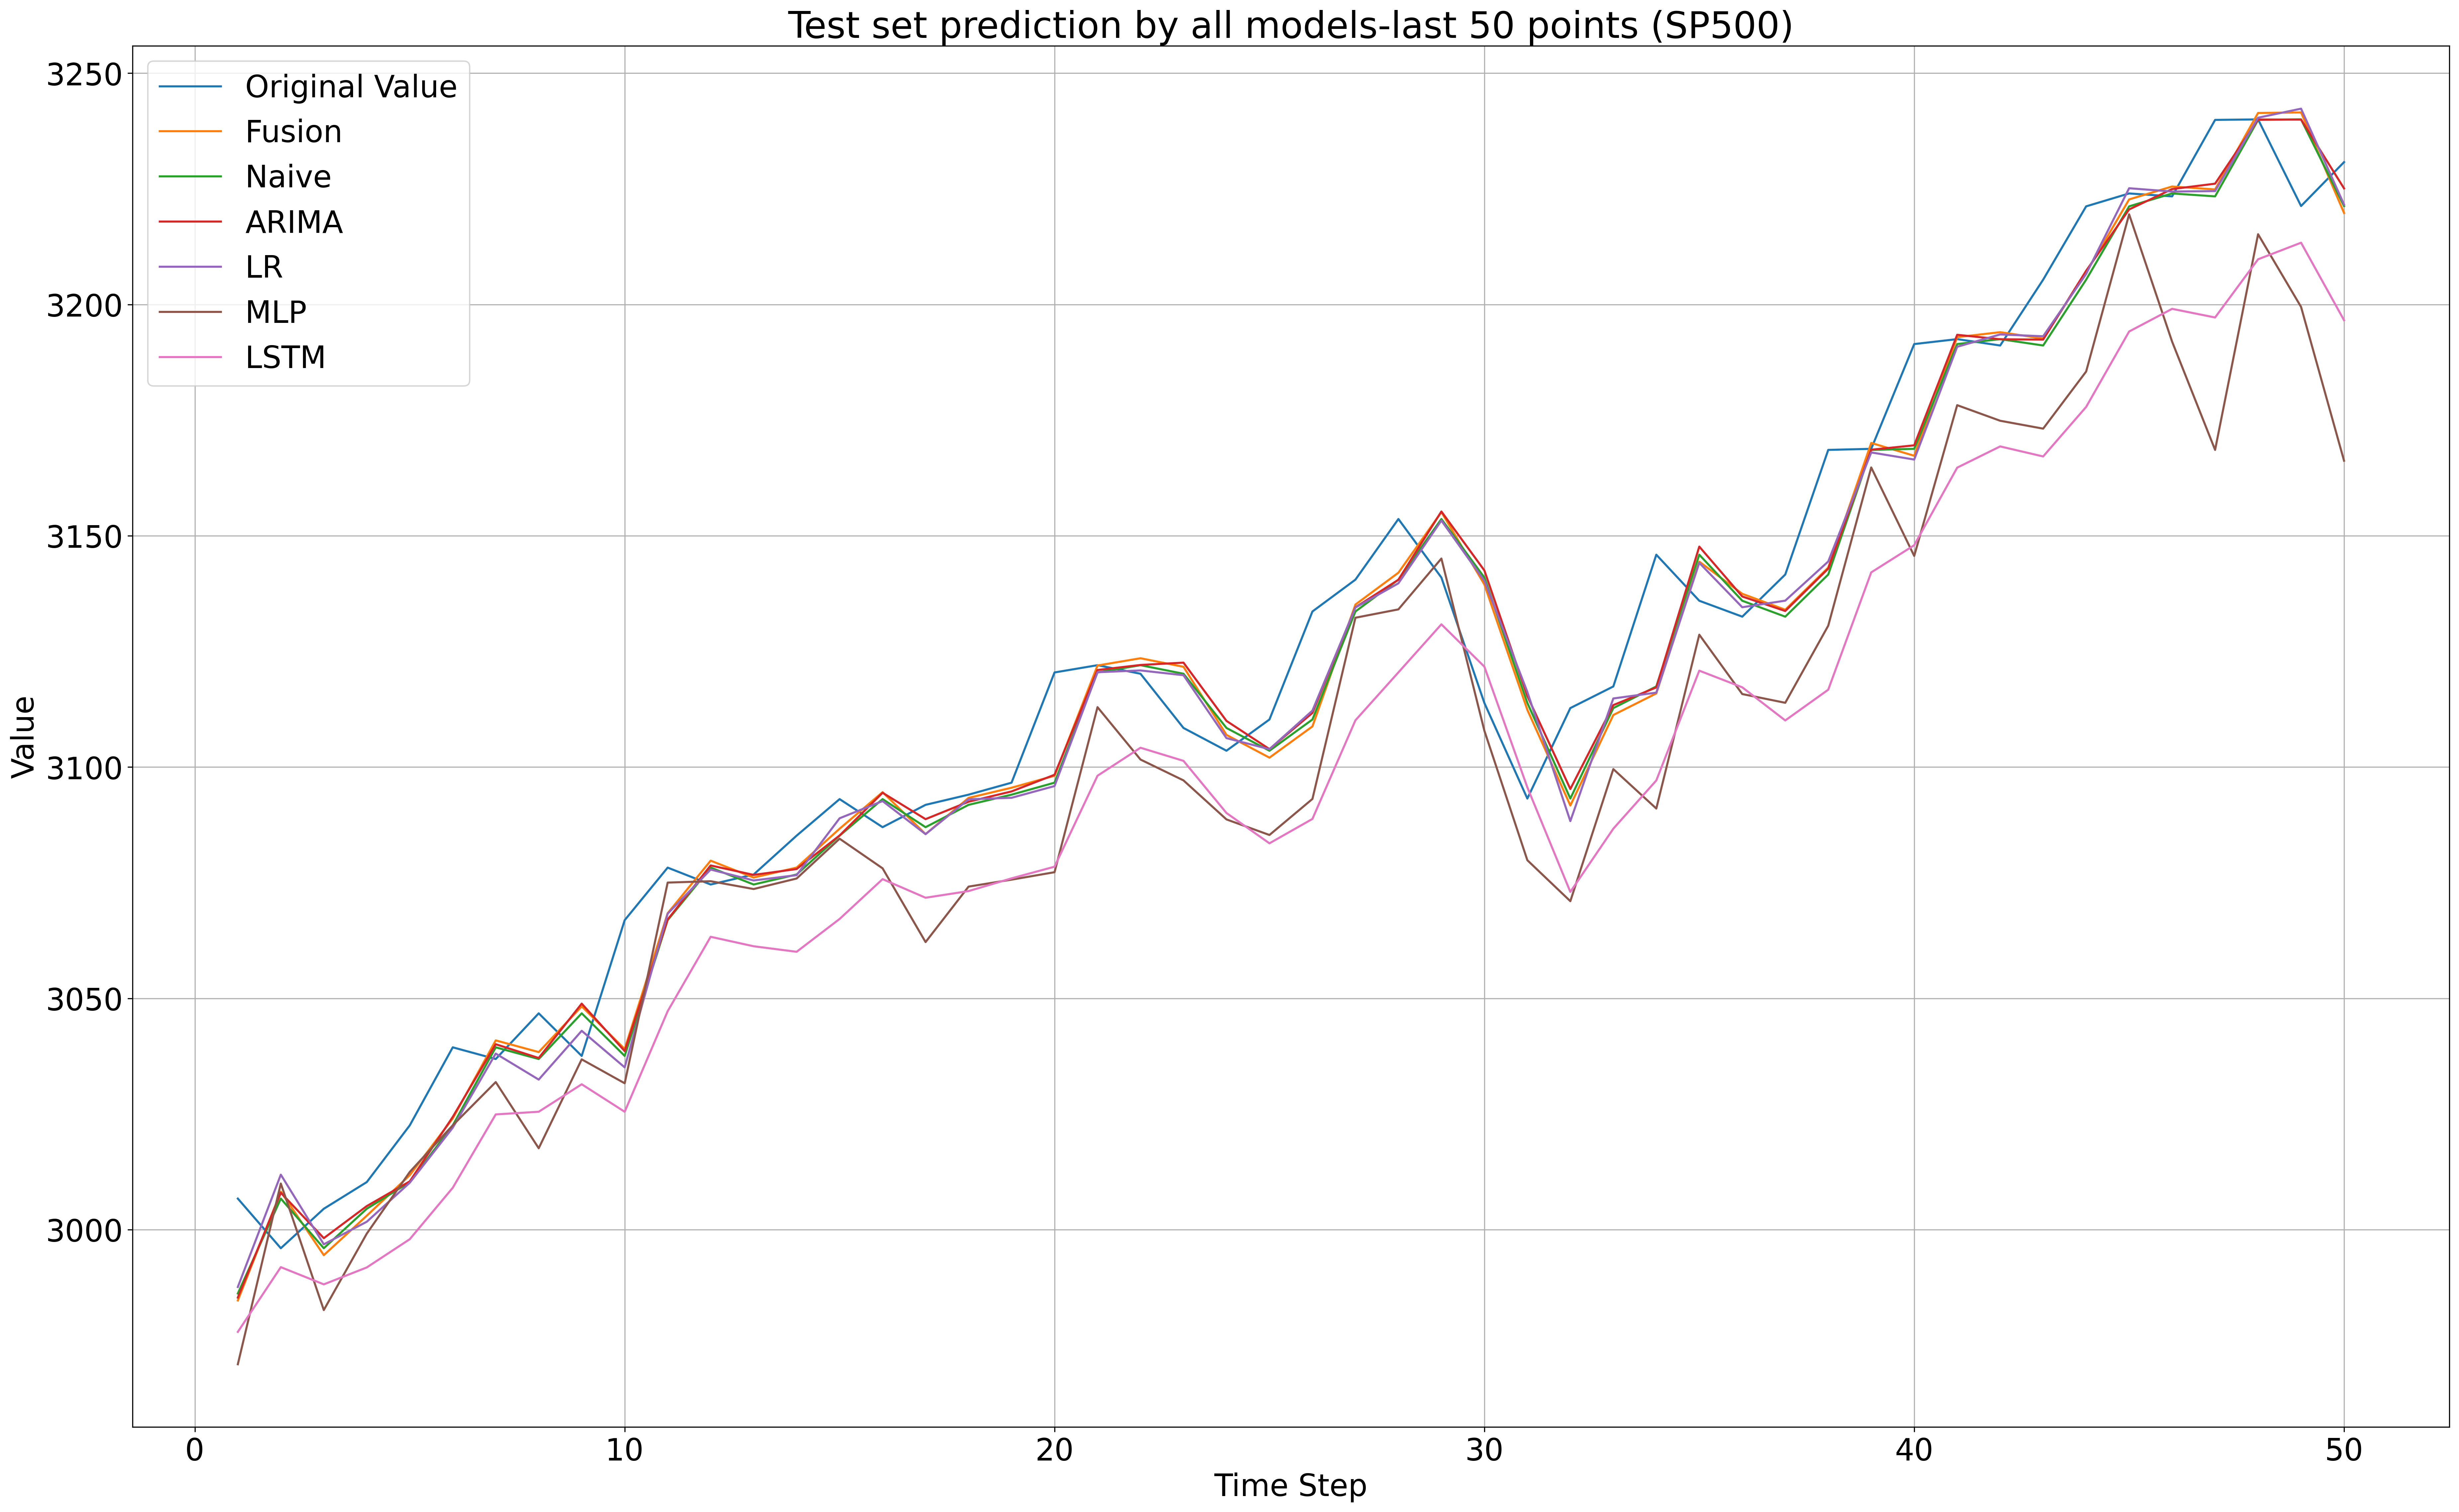

In [ ]:
# Plot the CNN-LSTM forecast
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30, 18),dpi = 300)
plot_series(np.arange( 1, G.SPLIT_TIME //8 + 1 ), raw_y_test[-50:])
plot_series(np.arange( 1, G.SPLIT_TIME //8 + 1 ), y_fusion[-50:])
plot_series(np.arange( 1, G.SPLIT_TIME //8 + 1 ), naive_test[-50:])
plot_series(np.arange( 1, G.SPLIT_TIME //8 + 1 ), ARIMA_predictions[-50:])
plot_series(np.arange( 1, G.SPLIT_TIME //8 + 1 ), series_prediction_list_LR[min_index_LR][-50:])
plot_series(np.arange( 1, G.SPLIT_TIME //8 + 1 ), series_prediction_list_MLP[min_index_MLP][-50:])
plot_series(np.arange( 1, G.SPLIT_TIME //8 + 1 ), series_prediction_list_LSTM[min_index_LSTM][-50:])


plt.ylabel("Value")
plt.xlabel("Time Step")
plt.title("Test set prediction by all models-last 50 points (SP500)")
legend_drawn_flag = True
plt.legend(["Original Value", "Fusion", "Naive", "ARIMA","LR","MLP","LSTM"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/ALL_MODELS_SP500.tif")

### Evaluation metrics comparison

In [ ]:
# Create a dictionary where keys are column names and values are your variables
data = {'Models':['Fusion','naive','ARIMA','LR', 'MLP', 'LSTM'],\
        'MAE': [mae_fusion, naive_mae, mae_test_ARIMA, mae_test_LR[min_index_LR], mae_test_MLP[min_index_MLP], mae_test_LSTM[min_index_LSTM]],\
        'MSE': [mse_fusion, naive_mse, mse_test_ARIMA, mse_test_LR[min_index_LR], mse_test_MLP[min_index_MLP], mse_test_LSTM[min_index_LSTM], ]}


# Create DataFrame
df = pd.DataFrame(data)

print(df)

   Models        MAE         MSE
0  Fusion  16.187902  490.912977
1   naive  16.277100  499.378612
2   ARIMA  16.338302  499.739638
3      LR  16.236584  497.368764
4     MLP  21.615049  775.427551
5    LSTM  21.148510  690.336853


In [ ]:
# Define the path where you want to save the CSV
csv_file_path = '/content/gdrive/MyDrive/Random_walk_prediction/files/performance_metrics_SP500.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

print(f"Performance data saved successfully to {csv_file_path}")

Performance data saved successfully to /content/gdrive/MyDrive/Random_walk_prediction/files/performance_metrics.csv


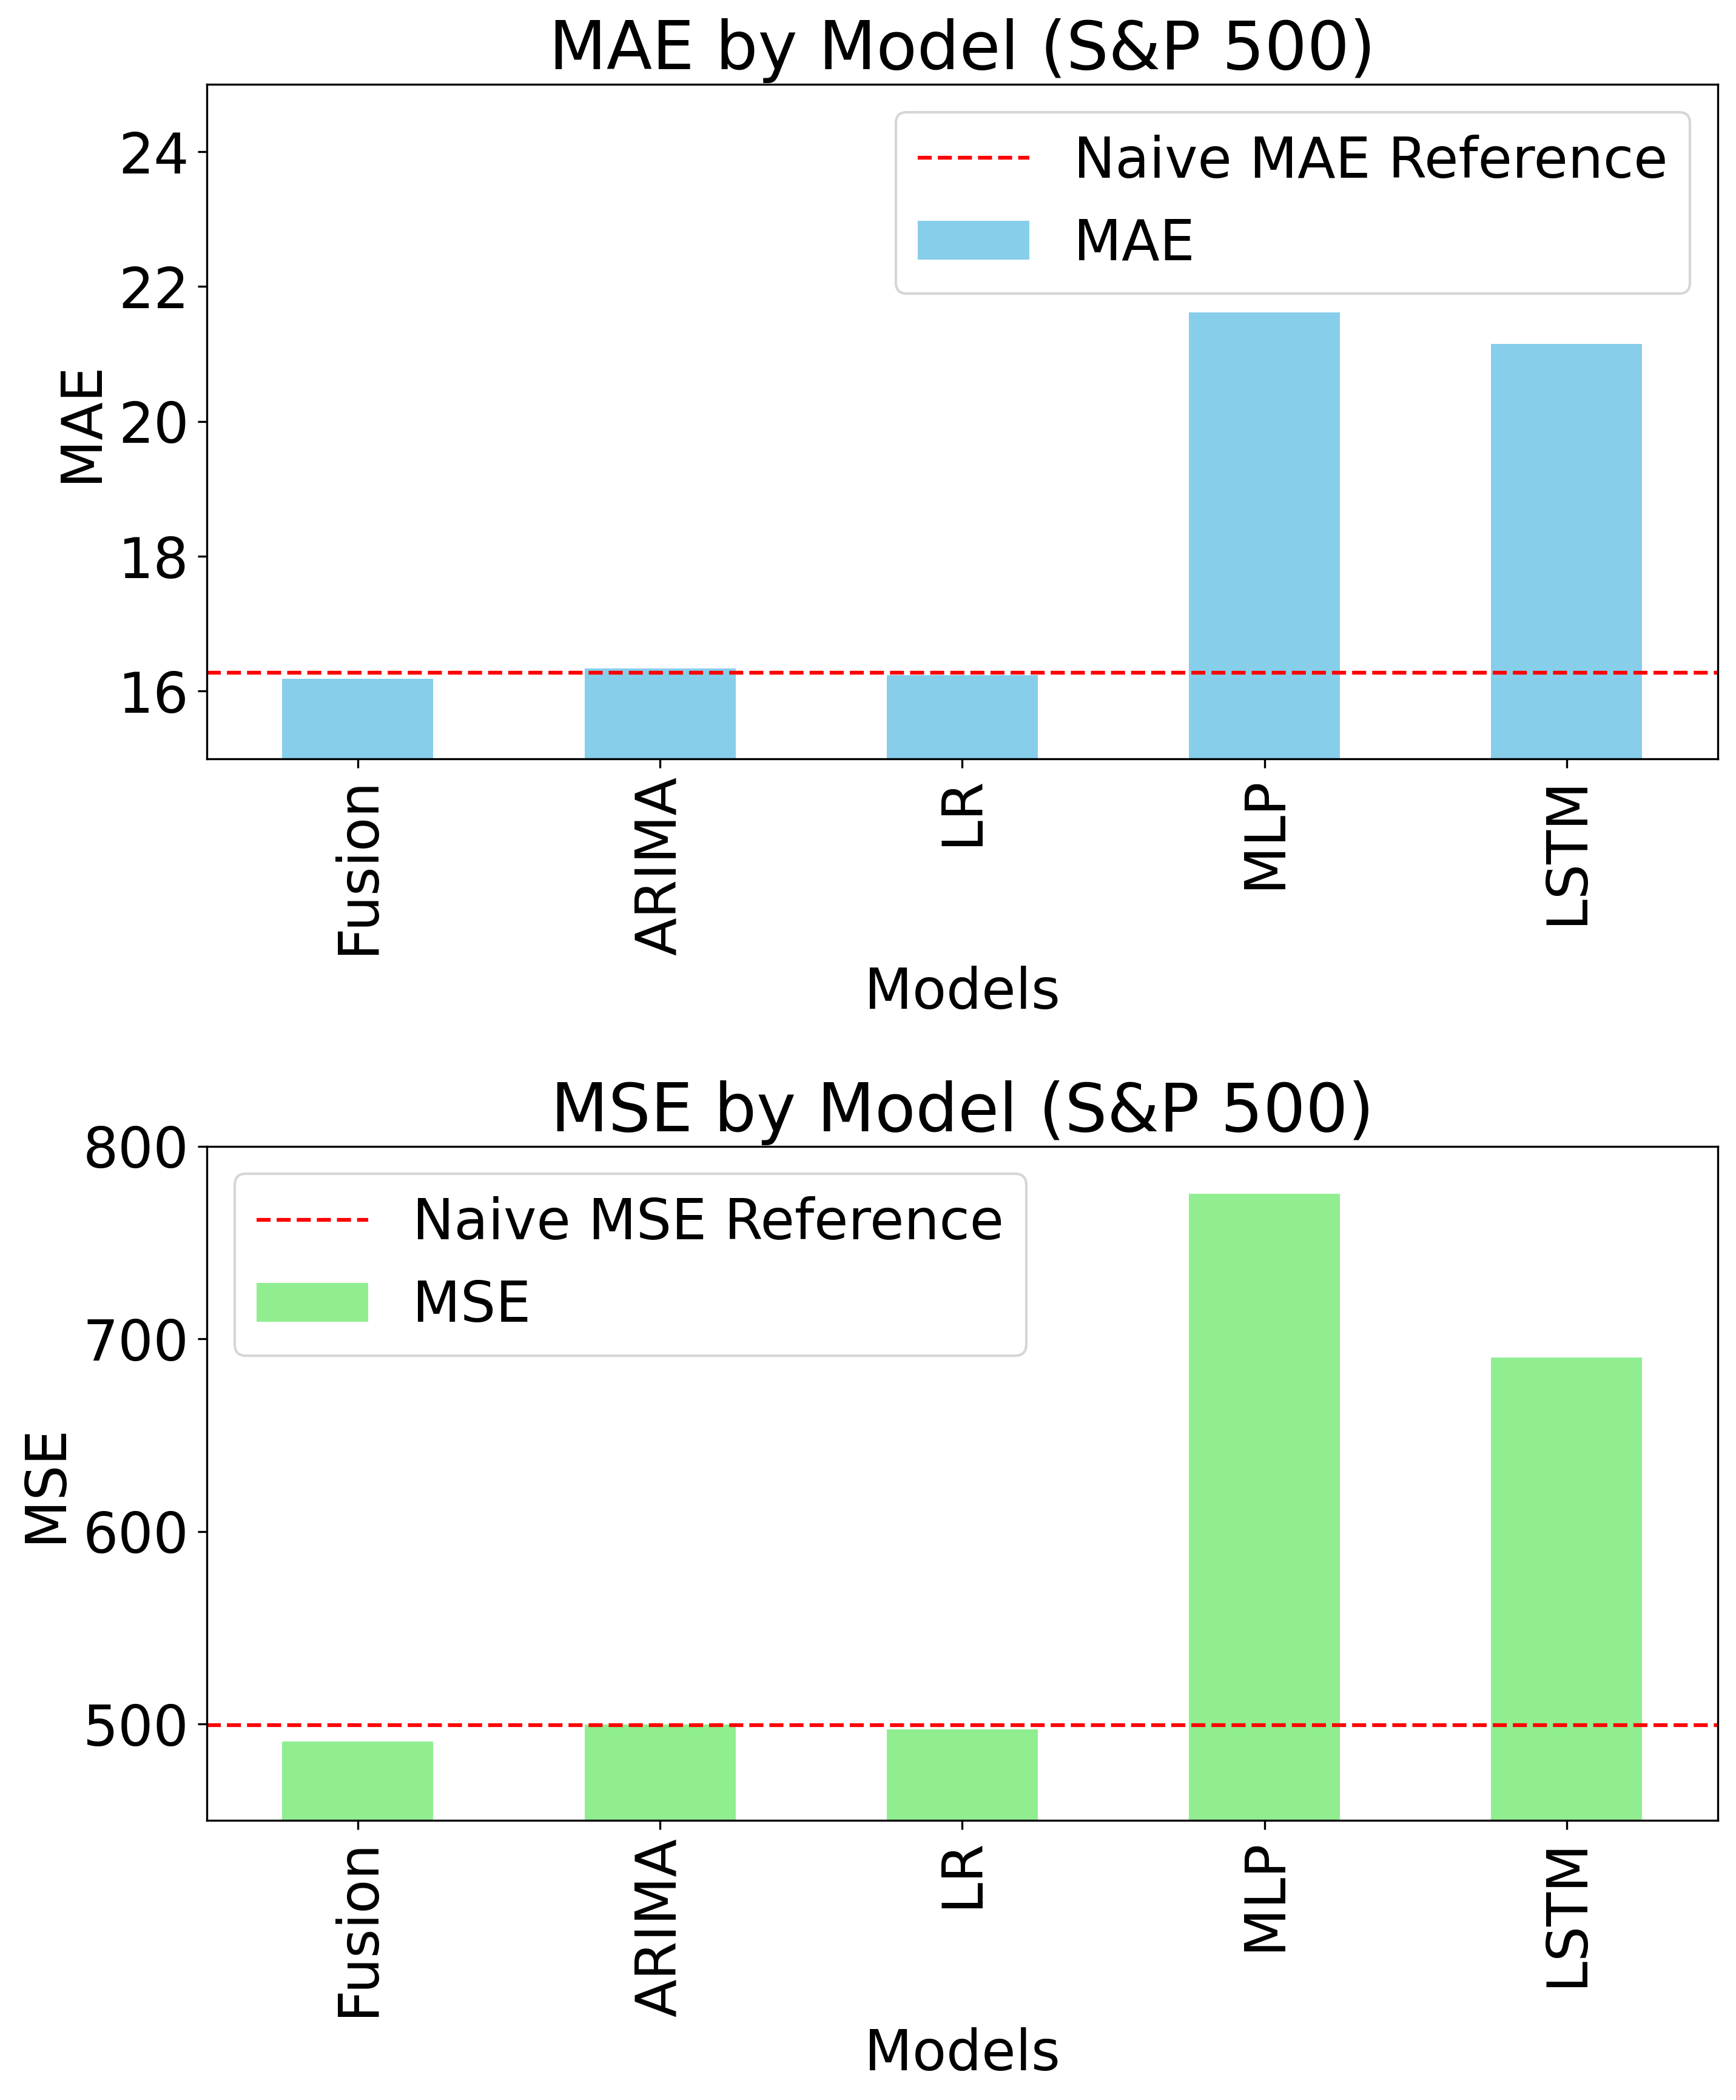

In [ ]:
# Remove the 'naive' data for bar plot, but save the values for reference line
naive_mae = df.loc[df['Models'] == 'naive', 'MAE'].values[0]
naive_mse = df.loc[df['Models'] == 'naive', 'MSE'].values[0]
df = df[df['Models'] != 'naive']

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 12), dpi = 300)  # Create 2 subplots for MAE and MSE

# MAE Plot
df.plot(kind='bar', x='Models', y='MAE', ax=ax[0], color='skyblue', legend=False)
ax[0].set_title('MAE by Model (S&P 500)')
ax[0].set_ylabel('MAE')
ax[0].axhline(y=naive_mae, color='r', linestyle='--', label='Naive MAE Reference')
ax[0].legend()
ax[0].set_ylim(15, 25)  # Adjust y-axis limits to zoom and focus on differences

# MSE Plot
df.plot(kind='bar', x='Models', y='MSE', ax=ax[1], color='lightgreen', legend=False)
ax[1].set_title('MSE by Model (S&P 500)')
ax[1].set_ylabel('MSE')
ax[1].axhline(y=naive_mse, color='r', linestyle='--', label='Naive MSE Reference')
ax[1].legend()
ax[1].set_ylim(450, 800)  # Adjust y-axis limits to zoom and focus on differences

plt.tight_layout()
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/ALL_MODELS_Comparison_SP500.tif")
plt.show()